# Lab 6.4: Regression Diagnostics

In [85]:
import yaml

from sqlalchemy import create_engine

pg_creds = yaml.load(open('../../pg_creds.yaml'))['student']

engine = create_engine('postgresql://{user}:{password}@{host}:{port}/{dbname}'.format(**pg_creds))


In [75]:
%pylab inline
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from seaborn import lmplot

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [76]:
homer = pd.read_csv('https://s3-us-west-2.amazonaws.com/dsci/6002/data/homer.csv')

In [77]:
homer.head()

,y,x1,x2,x3,x4,x5,x6
0,-2.17360,-0.023816,-0.012885,0.045936,-0.182890,0.028694,-0.81119
1,-1.29570,0.018453,0.058999,-0.072399,0.008679,-0.084344,-0.24208
2,0.14539,0.054999,0.131770,-0.067223,0.202430,0.127060,0.63388
3,0.92959,-0.018933,-0.010875,-0.028255,0.017912,0.084330,0.66062
4,0.90259,-0.000877,0.066941,-0.048190,0.064742,0.147880,0.26643


**Question 1**

Using the data in https://s3-us-west-2.amazonaws.com/dsci/6002/data/homer.csv :

1) Run a multiple regression model of $y$ against all the $x$ variables and then produce the residuals and fitted values. Create the residual diagnostic plot of residuals on the Y axis against the fitted values on the X axis. 

2) Is the linearity assumption met?  

3) Test for non-Normality.  

4) Test for heteroskedasticity. 

In [230]:
homer.dropna(axis=0, inplace=True)
X = homer[['x1', 'x2', 'x3', 'x4', 'x5', 'x6']]
Y = homer.y
X = sm.add_constant(X)  # <- add in constant term

model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     452.1
Date:                Sun, 09 Oct 2016   Prob (F-statistic):               0.00
Time:                        20:41:07   Log-Likelihood:                -8583.7
No. Observations:                6054   AIC:                         1.718e+04
Df Residuals:                    6047   BIC:                         1.723e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0069      0.013     -0.534      0.593        -0.032     0.018
x1             4.0686      0.508      8.015      0.000         3.073     5.064
x2             1.1412      0.257      4.442      0.000         0.638     1.645
x3             4.0318      0.358     11.249      0.000         3.329     4.734
x4             0.9373      0.127      7.362      0.000         0.688     1.187
x5             3.9840      0.171     23.316      0.000         3.649     4.319
x6             0.9967      0.022     44.744      0.000         0.953     1.040
==============================================================================
Omnibus:                      635.831   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.770
Skew:                           0.070   Prob(JB):                     7.54e-41
Kurtosis:                       2.156   Cond. No.                         41.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$$ y = (-0.00686) + (4.069)x_1 + (1.14)x_2 + (4.032)x_3 + (0.937)x_4 + (3.98)x_5 + (0.997)x_6 + e$$



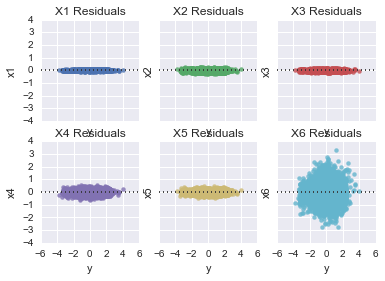

In [224]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True)
ax1 = sns.residplot(Y,homer['x1'], ax=ax1)
ax2 = sns.residplot(Y,homer['x2'], ax=ax2)
ax3 = sns.residplot(Y,homer['x3'], ax=ax3)
ax4 = sns.residplot(Y,homer['x4'], ax=ax4)
ax5 = sns.residplot(Y,homer['x5'], ax=ax5)
ax6 = sns.residplot(Y,homer['x6'], ax=ax6)
ax1.set_title('X1 Residuals')
ax2.set_title('X2 Residuals')
ax3.set_title('X3 Residuals')
ax4.set_title('X4 Residuals')
ax5.set_title('X5 Residuals')
ax6.set_title('X6 Residuals');

#### Question 1.2

The linear assumption is met for all variables. Their residual diagnostic scatter plots don't show any other patterns to indicate non-linearity.

#### Question 1.3 test for normality

based on the JB p-value and the histogram and qqplot of our residuals, we can reject the null that the data is normally distributed.

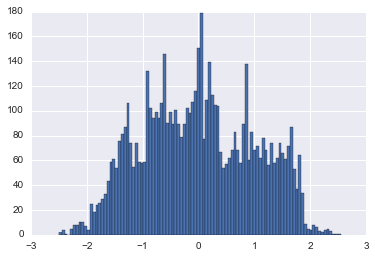

In [225]:
res = results.resid
hist(res, bins=100);

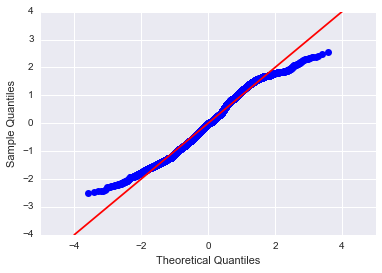

In [81]:
from statsmodels.graphics.gofplots import qqplot
qqplot(results.resid)
q = linspace(-4,4)
plot(q, q, color='r')
show()

#### Question 1.4 heteroskedasticity

In [84]:
from statsmodels.stats.diagnostic import het_breushpagan

het_breushpagan(results.resid, results.model.exog)[1]

1.0785837820695295e-09

^^^^

#### Our p-value is significant, so we can reject the null that variance is constant

In [87]:
hills = pd.read_sql("SELECT * FROM hills;", engine)

In [165]:
hills.head()

,Race,Distance,Climb,Time
0,Greenmantle,2.5,650,16.083
1,Carnethy,6.0,2500,48.350
2,CraigDunain,6.0,900,33.650
3,BenRha,7.5,800,45.600
4,BenLomond,8.0,3070,62.267


**Question 2**

You are given data about the Scottish Hill Climb races in the table `hills` which consists of 4 columns:

```
Race:     The name of the race (PK)
Distance: The distance of the race in miles
Climb:    Elevation climbed during race in feet
Time:     Record time for race in minutes
```

1) Explore the data with a scatter matrix and a correlation plot (`statsmodels.graphics.plot_corr`).  

   Build a multiple regression model to predict `Time` based on `Distance` and `Time`.
   

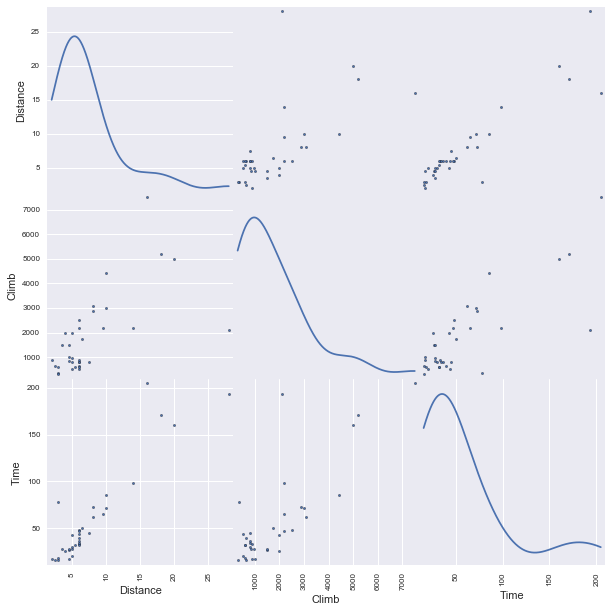

In [96]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(hills, alpha=1, figsize=(10, 10), diagonal='kde');

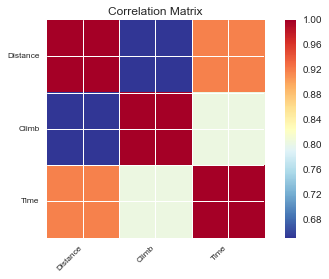

In [142]:
hills_corrs = hills.drop('Race', axis=1)
corr_matrix = np.corrcoef(hills_corrs.T)
sm.graphics.plot_corr(corr_matrix, xnames=list(hills.columns.values[1:]))
plt.show();

In [144]:
X2 = hills[['Distance', 'Climb']]
Y2 = hills.Time
X2 = sm.add_constant(X2)  # <- add in constant term

model2 = sm.OLS(Y2, X2)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Time   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     181.7
Date:                Sun, 09 Oct 2016   Prob (F-statistic):           3.40e-18
Time:                        18:59:05   Log-Likelihood:                -142.11
No. Observations:                  35   AIC:                             290.2
Df Residuals:                      32   BIC:                             294.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -8.9920      4.303     -2.090      0.045       -17.756    -0.228
Distance       6.2180      0.601     10.343      0.000         4.993     7.442
Climb          0.0110      0.002      5.387      0.000         0.007     0.015
==============================================================================
Omnibus:                       47.910   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.976
Skew:                           3.026   Prob(JB):                     1.56e-51
Kurtosis:                      14.127   Cond. No.                     4.20e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

2) Interpret the coefficients of your model.  



$$ y = b + (\beta_1)x_1 + (\beta_2)x_2 + \varepsilon $$

$$ time = (-8.9920) + (6.2180)(Distance) + (0.0110)(Climb) + \varepsilon $$

#### As distance increases by one, time increases by 6.22. As Climb increases by one, time increases by 0.011.

3) Plot the fitted values of the response (`Time`) against the standardized residuals of the model.

   **Hint:**
   - Use `model.fittedvalues` to get fitted values and `model.resid_pearson` to get the standardized residuals
 
   Does the residual plot appear to fulfill the following assumptions:
   - Linearity
   - Normality
   - Homoscedasticity 
   
   What are the consequences if those assumptions are not met ? 


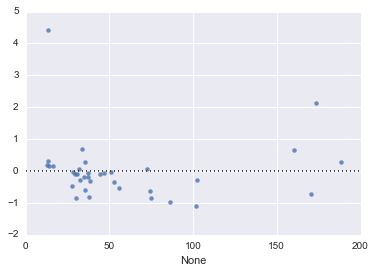

In [166]:
fitted_vals = results2.fittedvalues
std_resids = results2.resid_pearson
sns.residplot(fitted_vals, std_resids);

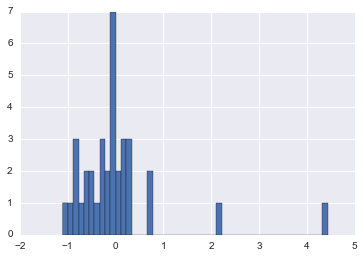

In [156]:
hist(std_resids, bins=50);

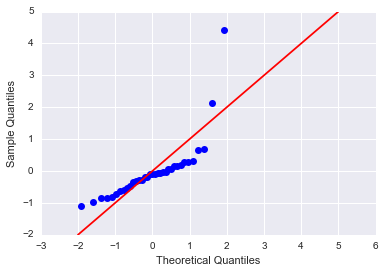

In [157]:
qqplot(std_resids)
q = linspace(-2,5)
plot(q, q, color='r')
show()

#### Question 3 & 4 commentary

+ The model seems to be non-linear as its residuals are somewhat spread out and non-random.
+ The histogram of its residuals also shows a non-normal distribution.
+ Its JB p-value is significant as well, so we can reject the null that the data is normally distributed.
+ the qq-plot also shows that our model is skewed by the extreme values and therefore doesn't accurately model the majority of our data. It's clear to see that we potentially have a non-linear relationship or we have two very out-of-the-ordinary outliers that we can ignore.

4) An additional test for Normality of the residuals is the Q-Q plot. If the quantiles of the residuals match that of a Normal distribution, then the residuals are normally distribution. 

   Import the qq-plot function from statsmodels `from statsmodels.graphics.gofplots import qqplot`.
   
   Draw a straight line where the quantiles of the residuals are the same as those of a standard Normal distribution.
   
   The plot you produce should look similar to the one below:
   
   ![](images/qq.png)
   
   Do the residuals appear to be Normal ?
  
   

5) (Extra Credit) To identify outliers, one can also look at the leverage-residual plot. 

   Explain what leverage means and how is leverage computed. Is a data point influential if the residual is large but the leverage is low? What about if the residual and leverage are both high?
   
   Import the leverage-residual plot from statsmodels by `from statsmodels.graphics.regressionplots import plot_leverage_resid2`. You can call it by just feeding in the fitted model.
   
   ```python
   plot_leverage_resid2(model)
   ```
   
   Identify the races where the leverage and residual are high. Comment on the commonalities between those races.
   
   

#### Question 2.5 attempt:

Leverage measures how far variable values are from other observations, or how influential outliers might be on other data points. It's calculated by taking the derivative of y_hat with respect to y. If residual is large and leverage is low, then it's not as influential. If it's got a high residual and leverage then it's more influential.

$\text{leverage} = h_{ii} = \frac {\delta \hat{y_i}}{\delta y_i}$

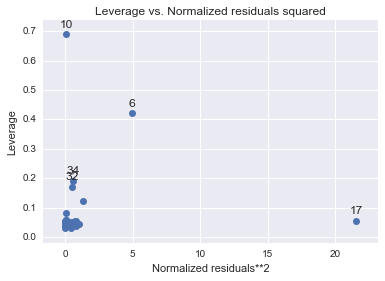

In [163]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2
plot_leverage_resid2(results2);

#### It looks like races 10, 6, and 17 are the most influential

6) (Extra Credit) What are the precautions you need to bare in mind if you were to remove the outliers you have identified in `5.` ?
   
   Remove the outliers in the dataset and re-run the model. 
   
   Plot the residual plot and Q-Q plot as you have done previously. Comment on the plots.
   
   Also comment on the fit of the model to the data relative to the first model.

#### Question 2.6 attempt:

+ Precautions: it's possible that our data is actually not linear and that those values are modeling something that our sample didn't adequately capture.

In [213]:
X3 = hills.drop(hills.index[[6,10,17]]).drop('Race', axis=1).drop('Time', axis=1)
Y3 = hills.drop(hills.index[[6,10,17]]).Time
X3 = sm.add_constant(X3)  # <- add in constant term

model3 = sm.OLS(Y3, X3)
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Time   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     544.1
Date:                Sun, 09 Oct 2016   Prob (F-statistic):           1.02e-23
Time:                        19:49:21   Log-Likelihood:                -101.92
No. Observations:                  32   AIC:                             209.8
Df Residuals:                      29   BIC:                             214.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -10.7171      2.147     -4.992      0.000       -15.108    -6.326
Distance       6.8377      0.467     14.647      0.000         5.883     7.792
Climb          0.0077      0.001      5.374      0.000         0.005     0.011
==============================================================================
Omnibus:                        5.917   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                4.255
Skew:                           0.778   Prob(JB):                        0.119
Kurtosis:                       3.879   Cond. No.                     4.22e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

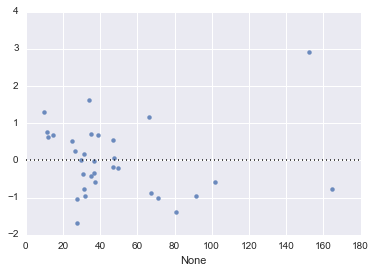

In [214]:
new_fitted_vals = results3.fittedvalues
new_std_resids = results3.resid_pearson
sns.residplot(new_fitted_vals, new_std_resids);

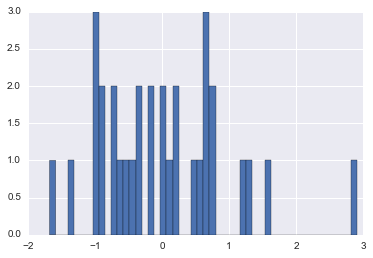

In [215]:
hist(new_std_resids, bins=50);

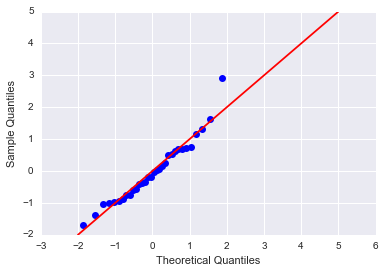

In [216]:
qqplot(new_std_resids)
q = linspace(-2,5)
plot(q, q, color='r')
show()

#### Question 2.6 commentary

+ The R^2 in our second model explains 6% more of the data, which is definitely a better fit, and our F-stat is bigger with a smaller p-value.
+ The residual plot is slightly better, more linear than the first, and the distribution appears to be more normal.
+ the qqplot does a much better job of modeling most of the data. There seems to be one more outlier, but it seems to not carry much leverage as the line of our model very well fits the bulk of the data.

**Question 3**

You are given the price and features of some used cars in the tables `car_price` and `car_type`. Car company X want you to build a model to predict car price based on some given features about the car.

1) Explore the dataset with a correlation matrix. You should select only numeric columns when you are constructing the correlation matrix.  
   ```python
   numerics_only = car_price.select_dtypes(['int64', 'float64'])
   sm.graphics.plot_corr(numerics_only.corr(), xnames=numerics_only.columns.tolist())
   ```

   Which 2 variables are strongly multicollinear with each other based on your observation of the correlation matrix ?
   
   Which one would you choose to put in the model and why (subjective answer).

In [235]:
car_price = pd.read_sql('SELECT * FROM car_price', engine)
car_type = pd.read_sql('SELECT * FROM car_type', engine)

In [236]:
car_price.head()

,car_id,price,mileage,make,model,trim,cruise,sound,leather
0,0,17314.103129,8221,Buick,Century,Sedan 4D,1,1,1
1,1,17542.036083,9135,Buick,Century,Sedan 4D,1,1,0
2,2,16218.847862,13196,Buick,Century,Sedan 4D,1,1,0
3,3,16336.913140,16342,Buick,Century,Sedan 4D,1,0,0
4,4,16339.170324,19832,Buick,Century,Sedan 4D,1,0,1


In [237]:
car_type.head()

,make,model,trim,type,cylinder,liter,doors
0,Buick,Century,Sedan 4D,Sedan,6,3.1,4
1,Buick,Lacrosse,CX Sedan 4D,Sedan,6,3.6,4
2,Buick,Lacrosse,CXL Sedan 4D,Sedan,6,3.6,4
3,Buick,Lacrosse,CXS Sedan 4D,Sedan,6,3.8,4
4,Buick,Lesabre,Custom Sedan 4D,Sedan,6,3.8,4


In [244]:
types_prices = pd.concat([car_price, car_type], axis=1).drop(['car_id','make', 'model', 'trim', 'type', 'cylinder', 'liter', 'doors'], axis=1)
types_prices.head()

,price,mileage,cruise,sound,leather
0,17314.103129,8221,1,1,1
1,17542.036083,9135,1,1,0
2,16218.847862,13196,1,1,0
3,16336.913140,16342,1,0,0
4,16339.170324,19832,1,0,1


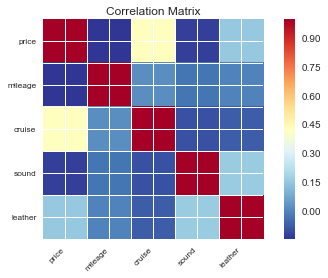

In [245]:
corr_matrix = np.corrcoef(types_prices.T)
sm.graphics.plot_corr(corr_matrix, xnames=list(types_prices.columns.values));

#### COMMENTARY:

based on the correlation matrix, price and cruise are multicollinear. We would keep price because it is more detailed information, while cruise seems to be either 1's or 0's. We would get better predictability with price.

2) Fit a multiple regression model with all the available features to predict price. Check all the assumptions made about the model as you have done previously. Comment on the Q-Q plot and the residual plot.

   

In [249]:
full_car = pd.read_sql("SELECT p.*, t.cylinder, t.liter, t.doors FROM car_price p LEFT OUTER JOIN car_type t ON p.make=t.make AND p.model=t.model AND p.trim=t.trim", engine)
full_car.head()

,car_id,price,mileage,make,model,trim,cruise,sound,leather,cylinder,liter,doors
0,0,17314.103129,8221,Buick,Century,Sedan 4D,1,1,1,6,3.1,4
1,1,17542.036083,9135,Buick,Century,Sedan 4D,1,1,0,6,3.1,4
2,2,16218.847862,13196,Buick,Century,Sedan 4D,1,1,0,6,3.1,4
3,3,16336.913140,16342,Buick,Century,Sedan 4D,1,0,0,6,3.1,4
4,4,16339.170324,19832,Buick,Century,Sedan 4D,1,0,1,6,3.1,4


In [275]:
import statsmodels.formula.api as smf
import patsy

In [251]:
model4 = smf.ols(formula='price ~ mileage + make + model + trim + cruise + sound + leather + cylinder + liter + doors', data=full_car)
results4 = model4.fit()
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1307.
Date:                Sun, 09 Oct 2016   Prob (F-statistic):               0.00
Time:                        21:31:45   Log-Likelihood:                -6574.1
No. Observations:                 804   AIC:                         1.330e+04
Df Residuals:                     730   BIC:                         1.364e+04
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                    5542.4854    221.014     25.078      0.000      5108.587  5976.384
make[T.Cadillac]             1.073e+04    125.388     85.596      0.000      1.05e+04   1.1e+04
make[T.Chevrolet]           -1706.0156    108.874    -15.670      0.000     -1919.759 -1492.272
make[T.Pontiac]             -2280.7785    117.116    -19.475      0.000     -2510.703 -2050.854
make[T.SAAB]                 8751.4068    396.090     22.094      0.000      7973.796  9529.018
make[T.Saturn]              -1313.8876     93.500    -14.052      0.000     -1497.448 -1130.327
model[T.9_3]                 3555.5749    310.744     11.442      0.000      2945.515  4165.634
model[T.9_3 HO]              4918.0832    608.883      8.077      0.000      3722.713  6113.453
model[T.9_5]                 5690.1367    514.242     11.065      0.000      4680.566  6699.707
model[T.9_5 HO]              6244.6803    758.727      8.230      0.000      4755.132  7734.228
model[T.AVEO]                -177.4172    221.160     -0.802      0.423      -611.602   256.768
model[T.Bonneville]         -3885.5443    193.548    -20.075      0.000     -4265.522 -3505.567
model[T.CST-V]               2310.6673    265.995      8.687      0.000      1788.460  2832.874
model[T.CTS]                -1044.0901    256.907     -4.064      0.000     -1548.455  -539.725
model[T.Cavalier]             490.4066    154.077      3.183      0.002       187.920   792.893
model[T.Century]            -4858.1677    252.742    -19.222      0.000     -5354.355 -4361.981
model[T.Classic]             2019.1504    286.738      7.042      0.000      1456.222  2582.079
model[T.Cobalt]              1444.4619    142.487     10.137      0.000      1164.728  1724.196
model[T.Corvette]            5385.6399    278.285     19.353      0.000      4839.306  5931.974
model[T.Deville]            -7260.4932    253.870    -28.599      0.000     -7758.895 -6762.092
model[T.G6]                    61.2471    238.456      0.257      0.797      -406.894   529.389
model[T.GTO]                 -465.9656    276.271     -1.687      0.092     -1008.346    76.415
model[T.Grand Am]            -868.4237    249.522     -3.480      0.001     -1358.291  -378.557
model[T.Grand Prix]         -3131.4772    246.616    -12.698      0.000     -3615.638 -2647.317
model[T.Impala]             -2911.3944    211.278    -13.780      0.000     -3326.180 -2496.608
model[T.Ion]                 1167.5443    133.572      8.741      0.000       905.314  1429.775
model[T.L Series]           -2481.4319    123.849    -20.036      0.000     -2724.574 -2238.290
model[T.Lacrosse]           -1830.6207    135.592    -13.501      0.000     -2096.818 -1564.423
model[T.Lesabre]            -2757.6140    145.755    -18.920      0.000     -3043.762 -2471.466
model[T.Mal

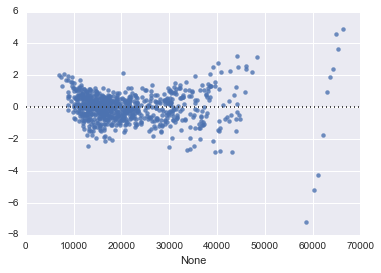

In [252]:
car_fitted_vals = results4.fittedvalues
car_std_resids = results4.resid_pearson
sns.residplot(car_fitted_vals, car_std_resids);

#### Residual scatter commentary

It seems like there are some outliers in our data, and that there could be a non-linear relationship.

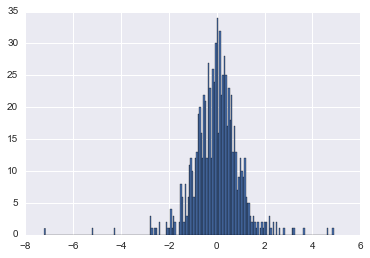

In [259]:
hist(car_std_resids, bins=200);

#### histogram commentary

Our residuals look to have a very normal distribution with some outliers in both directions, favoring a left-skew. However, our JB p-value is essentially zero, so we can reject the null that the distribution is normal.

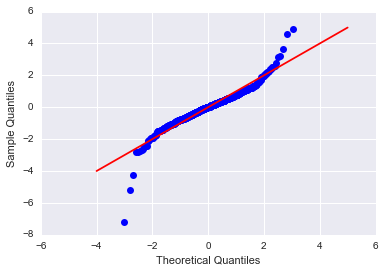

In [257]:
qqplot(car_std_resids)
q = linspace(-4,5)
plot(q, q, color='r')
show()

#### qqplot commentary

save for some extreme values on the low and high ends of the distribution, our model seems to do a pretty good job of describing the relationships between our indepenedent and dependent variables. However, we could get a better fit.

3) One of the remedies to heteroskedastic residuals is to take the log of the response. Log the response and re-run the model and check the assumptions again.

   

In [297]:
log_f = np.log(test_f)
f = 'price ~ mileage + make + model + trim + cruise + sound + leather + cylinder + liter + doors'
test_f, test_X = patsy.dmatrices(f, full_car, return_type='dataframe')

In [298]:
model8 = smf.OLS(log_f, test_X)
results8 = model8.fit()
results8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2973.
Date:                Sun, 09 Oct 2016   Prob (F-statistic):               0.00
Time:                        22:45:10   Log-Likelihood:                 1866.9
No. Observations:                 804   AIC:                            -3586.
Df Residuals:                     730   BIC:                            -3239.
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                       3.7240      0.006    611.151      0.000         3.712     3.736
make[T.Cadillac]               -0.0248      0.003     -7.185      0.000        -0.032    -0.018
make[T.Chevrolet]               0.5807      0.003    193.463      0.000         0.575     0.587
make[T.Pontiac]                 0.3444      0.003    106.672      0.000         0.338     0.351
make[T.SAAB]                    1.8787      0.011    172.038      0.000         1.857     1.900
make[T.Saturn]                  0.4082      0.003    158.359      0.000         0.403     0.413
model[T.9_3]                    0.1681      0.009     19.616      0.000         0.151     0.185
model[T.9_3 HO]                -0.1654      0.017     -9.855      0.000        -0.198    -0.132
model[T.9_5]                    0.0676      0.014      4.770      0.000         0.040     0.095
model[T.9_5 HO]                 0.0968      0.021      4.626      0.000         0.056     0.138
model[T.AVEO]                   0.1263      0.006     20.707      0.000         0.114     0.138
model[T.Bonneville]            -0.6773      0.005   -126.926      0.000        -0.688    -0.667
model[T.CST-V]                  0.1358      0.007     18.524      0.000         0.121     0.150
model[T.CTS]                    0.2117      0.007     29.889      0.000         0.198     0.226
model[T.Cavalier]               0.6515      0.004    153.361      0.000         0.643     0.660
model[T.Century]               -0.2429      0.007    -34.859      0.000        -0.257    -0.229
model[T.Classic]                0.7584      0.008     95.929      0.000         0.743     0.774
model[T.Cobalt]                 0.7376      0.004    187.759      0.000         0.730     0.745
model[T.Corvette]              -0.4851      0.008    -63.221      0.000        -0.500    -0.470
model[T.Deville]               -0.8643      0.007   -123.488      0.000        -0.878    -0.851
model[T.G6]                    -0.1452      0.007    -22.090      0.000        -0.158    -0.132
model[T.GTO]                   -0.6431      0.008    -84.433      0.000        -0.658    -0.628
model[T.Grand Am]               0.3011      0.007     43.763      0.000         0.288     0.315
model[T.Grand Prix]            -0.0987      0.007    -14.515      0.000        -0.112    -0.085
model[T.Impala]                -0.2911      0.006    -49.970      0.000        -0.303    -0.280
model[T.Ion]                    0.8867      0.004    240.794      0.000         0.880     0.894
model[T.L Series]              -0.4785      0.003   -140.144      0.000        -0.485    -0.472
model[T.Lacrosse]               0.1081      0.004     28.904      0.000         0.101     0.115
model[T.Lesabre]                0.1058      0.004     26.319      0.000         0.098     0.114
model[T.Mal

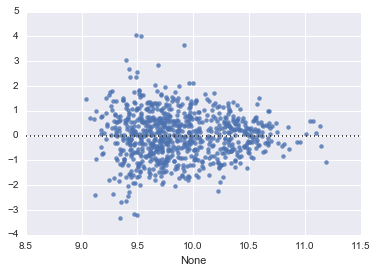

In [299]:
car_fitted_vals_2 = results8.fittedvalues
car_std_resids_2 = results8.resid_pearson
sns.residplot(car_fitted_vals_2, car_std_resids_2);

#### Commentary on residuals

We have an improvement from last time as our residuals show less non-linearity

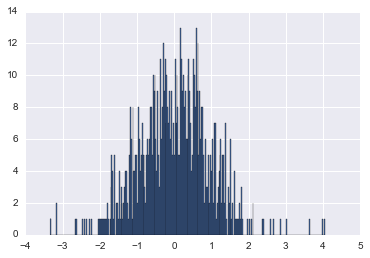

In [302]:
hist(car_std_resids_2, bins=300);

#### commentary on histogram and JB:

we have an improvement here as well as our distribution appears more normal and our JB stat has lowered and our JB p-value has increased, although it is still significant, so we have to reject the null that the distribution is normal.

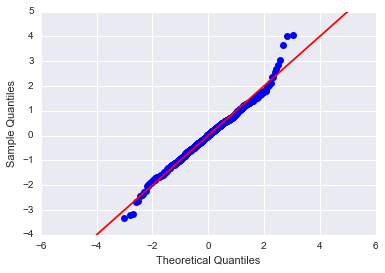

In [303]:
qqplot(car_std_resids_2)
q = linspace(-4,5)
plot(q, q, color='r')
show()

#### qqplot commentary:

also, this has improved but there is still some data that lies outside the model, so we still have non-linearity and heteroscetasticity.

4) As a rule of thumb, the fewer variables there are in a model, the easier it is to interpret the model. Use your judgement and remove features which you think are of little practical importance and have coefficients that are statistically insignificant.

   

In [308]:
test_X2 = test_X.drop('trim[T.Arc Wagon 4D]', axis=1)
model9 = smf.OLS(log_f, test_X2)
results9 = model9.fit()
results9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2973.
Date:                Mon, 10 Oct 2016   Prob (F-statistic):               0.00
Time:                        00:00:53   Log-Likelihood:                 1866.9
No. Observations:                 804   AIC:                            -3586.
Df Residuals:                     730   BIC:                            -3239.
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                       3.7238      0.006    608.218      0.000         3.712     3.736
make[T.Cadillac]               -0.0248      0.003     -7.183      0.000        -0.032    -0.018
make[T.Chevrolet]               0.5802      0.003    179.515      0.000         0.574     0.587
make[T.Pontiac]                 0.3439      0.003    100.587      0.000         0.337     0.351
make[T.SAAB]                    1.8821      0.013    147.533      0.000         1.857     1.907
make[T.Saturn]                  0.4078      0.003    148.996      0.000         0.402     0.413
model[T.9_3]                    0.1655      0.010     16.489      0.000         0.146     0.185
model[T.9_3 HO]                -0.1651      0.017     -9.779      0.000        -0.198    -0.132
model[T.9_5]                    0.0677      0.014      4.802      0.000         0.040     0.095
model[T.9_5 HO]                 0.0969      0.021      4.619      0.000         0.056     0.138
model[T.AVEO]                   0.1264      0.006     20.693      0.000         0.114     0.138
model[T.Bonneville]            -0.6772      0.005   -126.412      0.000        -0.688    -0.667
model[T.CST-V]                  0.1354      0.007     18.375      0.000         0.121     0.150
model[T.CTS]                    0.2118      0.007     29.910      0.000         0.198     0.226
model[T.Cavalier]               0.6512      0.004    151.558      0.000         0.643     0.660
model[T.Century]               -0.2430      0.007    -34.829      0.000        -0.257    -0.229
model[T.Classic]                0.7581      0.008     95.683      0.000         0.743     0.774
model[T.Cobalt]                 0.7373      0.004    185.602      0.000         0.730     0.745
model[T.Corvette]              -0.4852      0.008    -63.209      0.000        -0.500    -0.470
model[T.Deville]               -0.8641      0.007   -123.210      0.000        -0.878    -0.850
model[T.G6]                    -0.1451      0.007    -22.008      0.000        -0.158    -0.132
model[T.GTO]                   -0.6431      0.008    -84.414      0.000        -0.658    -0.628
model[T.Grand Am]               0.3010      0.007     43.661      0.000         0.287     0.314
model[T.Grand Prix]            -0.0987      0.007    -14.521      0.000        -0.112    -0.085
model[T.Impala]                -0.2911      0.006    -49.966      0.000        -0.303    -0.280
model[T.Ion]                    0.8864      0.004    235.636      0.000         0.879     0.894
model[T.L Series]              -0.4786      0.003   -140.035      0.000        -0.485    -0.472
model[T.Lacrosse]               0.1074      0.004     26.926      0.000         0.100     0.115
model[T.Lesabre]                0.1051      0.004     24.861      0.000         0.097     0.113
model[T.Mal

In [317]:
test_X3 = test_X2.drop('trim[T.CXL Sedan 4D]', axis=1)
model10 = smf.OLS(log_f, test_X3)
results10 = model10.fit()
results10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2973.
Date:                Mon, 10 Oct 2016   Prob (F-statistic):               0.00
Time:                        00:14:20   Log-Likelihood:                 1866.9
No. Observations:                 804   AIC:                            -3586.
Df Residuals:                     730   BIC:                            -3239.
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                       3.7238      0.006    608.236      0.000         3.712     3.736
make[T.Cadillac]               -0.0243      0.004     -6.824      0.000        -0.031    -0.017
make[T.Chevrolet]               0.5806      0.003    177.883      0.000         0.574     0.587
make[T.Pontiac]                 0.3444      0.003     99.343      0.000         0.338     0.351
make[T.SAAB]                    1.8825      0.013    146.952      0.000         1.857     1.908
make[T.Saturn]                  0.4081      0.003    147.183      0.000         0.403     0.414
model[T.9_3]                    0.1655      0.010     16.494      0.000         0.146     0.185
model[T.9_3 HO]                -0.1651      0.017     -9.774      0.000        -0.198    -0.132
model[T.9_5]                    0.0678      0.014      4.805      0.000         0.040     0.095
model[T.9_5 HO]                 0.0969      0.021      4.620      0.000         0.056     0.138
model[T.AVEO]                   0.1265      0.006     20.711      0.000         0.114     0.138
model[T.Bonneville]            -0.6770      0.005   -126.299      0.000        -0.688    -0.666
model[T.CST-V]                  0.1354      0.007     18.371      0.000         0.121     0.150
model[T.CTS]                    0.2119      0.007     29.898      0.000         0.198     0.226
model[T.Cavalier]               0.6512      0.004    151.558      0.000         0.643     0.660
model[T.Century]               -0.2424      0.007    -34.178      0.000        -0.256    -0.229
model[T.Classic]                0.7581      0.008     95.683      0.000         0.743     0.774
model[T.Cobalt]                 0.7373      0.004    185.601      0.000         0.730     0.745
model[T.Corvette]              -0.4851      0.008    -63.213      0.000        -0.500    -0.470
model[T.Deville]               -0.8640      0.007   -123.119      0.000        -0.878    -0.850
model[T.G6]                    -0.1450      0.007    -21.989      0.000        -0.158    -0.132
model[T.GTO]                   -0.6430      0.008    -84.412      0.000        -0.658    -0.628
model[T.Grand Am]               0.3010      0.007     43.664      0.000         0.287     0.315
model[T.Grand Prix]            -0.0987      0.007    -14.517      0.000        -0.112    -0.085
model[T.Impala]                -0.2910      0.006    -49.946      0.000        -0.302    -0.280
model[T.Ion]                    0.8865      0.004    235.518      0.000         0.879     0.894
model[T.L Series]              -0.4784      0.003   -139.391      0.000        -0.485    -0.472
model[T.Lacrosse]               0.1037      0.007     13.956      0.000         0.089     0.118
model[T.Lesabre]                0.1055      0.004     24.778      0.000         0.097     0.114
model[T.Mal

In [318]:
test_X4 = test_X3.drop('trim[T.GT Sportwagon]', axis=1)
model11 = smf.OLS(log_f, test_X4)
results11 = model11.fit()
results11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     3007.
Date:                Mon, 10 Oct 2016   Prob (F-statistic):               0.00
Time:                        00:14:22   Log-Likelihood:                 1865.4
No. Observations:                 804   AIC:                            -3585.
Df Residuals:                     731   BIC:                            -3242.
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                       3.7233      0.006    608.283      0.000         3.711     3.735
make[T.Cadillac]               -0.0245      0.004     -6.858      0.000        -0.031    -0.017
make[T.Chevrolet]               0.5807      0.003    177.723      0.000         0.574     0.587
make[T.Pontiac]                 0.3432      0.003    101.014      0.000         0.336     0.350
make[T.SAAB]                    1.8828      0.013    146.806      0.000         1.858     1.908
make[T.Saturn]                  0.4084      0.003    147.361      0.000         0.403     0.414
model[T.9_3]                    0.1656      0.010     16.481      0.000         0.146     0.185
model[T.9_3 HO]                -0.1648      0.017     -9.748      0.000        -0.198    -0.132
model[T.9_5]                    0.0679      0.014      4.810      0.000         0.040     0.096
model[T.9_5 HO]                 0.0970      0.021      4.619      0.000         0.056     0.138
model[T.AVEO]                   0.1271      0.006     20.838      0.000         0.115     0.139
model[T.Bonneville]            -0.6764      0.005   -126.321      0.000        -0.687    -0.666
model[T.CST-V]                  0.1347      0.007     18.286      0.000         0.120     0.149
model[T.CTS]                    0.2124      0.007     29.960      0.000         0.198     0.226
model[T.Cavalier]               0.6515      0.004    151.594      0.000         0.643     0.660
model[T.Century]               -0.2423      0.007    -34.116      0.000        -0.256    -0.228
model[T.Classic]                0.7584      0.008     95.632      0.000         0.743     0.774
model[T.Cobalt]                 0.7377      0.004    185.729      0.000         0.730     0.745
model[T.Corvette]              -0.4861      0.008    -63.457      0.000        -0.501    -0.471
model[T.Deville]               -0.8640      0.007   -122.969      0.000        -0.878    -0.850
model[T.G6]                    -0.1439      0.007    -21.902      0.000        -0.157    -0.131
model[T.GTO]                   -0.6425      0.008    -84.299      0.000        -0.658    -0.628
model[T.Grand Am]               0.3024      0.007     44.114      0.000         0.289     0.316
model[T.Grand Prix]            -0.0978      0.007    -14.410      0.000        -0.111    -0.084
model[T.Impala]                -0.2913      0.006    -49.967      0.000        -0.303    -0.280
model[T.Ion]                    0.8867      0.004    235.376      0.000         0.879     0.894
model[T.L Series]              -0.4783      0.003   -139.205      0.000        -0.485    -0.472
model[T.Lacrosse]               0.1039      0.007     13.959      0.000         0.089     0.118
model[T.Lesabre]                0.1055      0.004     24.751      0.000         0.097     0.114
model[T.Mal

#### commentary on removing explanatory variables

This last stepwise regression seems to do an adequate job of removing varaibles with significant p-values. This still has an enormous amount of variables, but our r^2 and adjusted r^2 are nearly perfect, as is our f-stat/p-value.

5) (Extra Credit) Run outlier diagnostics in order to identify and explain outliers of the model.

## Outlier analysis attempt

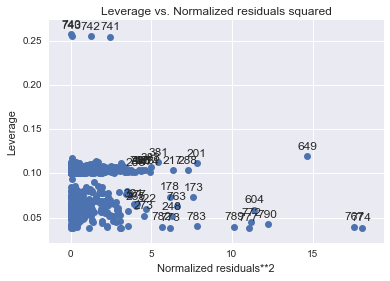

In [311]:
plot_leverage_resid2(results11);

#### it appears that values 740, 743, 742, and 741 are outliers with high leverage. We will examine them and see how removing them may affect our results.

In [319]:
# test_X4.drop(test_X4['Intercept'], inplace=True, axis=0)
test_X4.head()

,Intercept,make[T.Cadillac],make[T.Chevrolet],make[T.Pontiac],make[T.SAAB],make[T.Saturn],model[T.9_3],model[T.9_3 HO],model[T.9_5],model[T.9_5 HO],...,trim[T.Sedan 4D],trim[T.Special Ed Ultra 4D],trim[T.Sportwagon 4D],mileage,cruise,sound,leather,cylinder,liter,doors
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,8221.0,1.0,1.0,1.0,6.0,3.1,4.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,9135.0,1.0,1.0,0.0,6.0,3.1,4.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,13196.0,1.0,1.0,0.0,6.0,3.1,4.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,16342.0,1.0,0.0,0.0,6.0,3.1,4.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,19832.0,1.0,0.0,1.0,6.0,3.1,4.0


In [320]:
X_out = test_X4.drop(test_X4.index[[740,741,742,742]])
Y_out = log_f.drop(log_f.index[[740,741,742,742]])

model12 = sm.OLS(Y_out, X_out)
results12 = model12.fit()
results12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     3004.
Date:                Mon, 10 Oct 2016   Prob (F-statistic):               0.00
Time:                        00:16:27   Log-Likelihood:                 1858.8
No. Observations:                 801   AIC:                            -3572.
Df Residuals:                     728   BIC:                            -3230.
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                       3.7219      0.008    469.139      0.000         3.706     3.737
make[T.Cadillac]               -0.0244      0.004     -6.827      0.000        -0.031    -0.017
make[T.Chevrolet]               0.5813      0.004    148.373      0.000         0.574     0.589
make[T.Pontiac]                 0.3437      0.004     88.155      0.000         0.336     0.351
make[T.SAAB]                    1.8784      0.021     89.980      0.000         1.837     1.919
make[T.Saturn]                  0.4087      0.003    139.426      0.000         0.403     0.414
model[T.9_3]                    0.1688      0.016     10.758      0.000         0.138     0.200
model[T.9_3 HO]                -0.1597      0.026     -6.259      0.000        -0.210    -0.110
model[T.9_5]                    0.0737      0.025      2.955      0.003         0.025     0.123
model[T.9_5 HO]                 0.1026      0.029      3.482      0.001         0.045     0.160
model[T.AVEO]                   0.1264      0.007     19.095      0.000         0.113     0.139
model[T.Bonneville]            -0.6765      0.005   -126.200      0.000        -0.687    -0.666
model[T.CST-V]                  0.1359      0.009     15.922      0.000         0.119     0.153
model[T.CTS]                    0.2118      0.007     28.370      0.000         0.197     0.226
model[T.Cavalier]               0.6517      0.004    150.756      0.000         0.643     0.660
model[T.Century]               -0.2426      0.007    -33.854      0.000        -0.257    -0.229
model[T.Classic]                0.7586      0.008     95.508      0.000         0.743     0.774
model[T.Cobalt]                 0.7379      0.004    184.450      0.000         0.730     0.746
model[T.Corvette]              -0.4851      0.008    -57.695      0.000        -0.502    -0.469
model[T.Deville]               -0.8643      0.007   -120.678      0.000        -0.878    -0.850
model[T.G6]                    -0.1441      0.007    -21.773      0.000        -0.157    -0.131
model[T.GTO]                   -0.6419      0.008    -81.029      0.000        -0.657    -0.626
model[T.Grand Am]               0.3024      0.007     44.107      0.000         0.289     0.316
model[T.Grand Prix]            -0.0977      0.007    -14.322      0.000        -0.111    -0.084
model[T.Impala]                -0.2912      0.006    -49.823      0.000        -0.303    -0.280
model[T.Ion]                    0.8872      0.004    214.862      0.000         0.879     0.895
model[T.L Series]              -0.4785      0.004   -136.221      0.000        -0.485    -0.472
model[T.Lacrosse]               0.1046      0.008     13.296      0.000         0.089     0.120
model[T.Lesabre]                0.1061      0.005     21.634      0.000         0.096     0.116
model[T.Mal

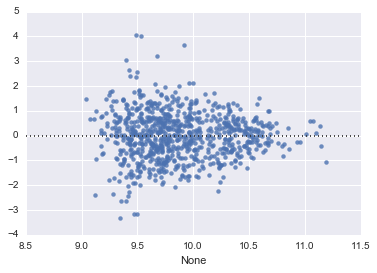

In [321]:
out_fitted_vals = results12.fittedvalues
out_std_resids = results12.resid_pearson
sns.residplot(out_fitted_vals, out_std_resids);

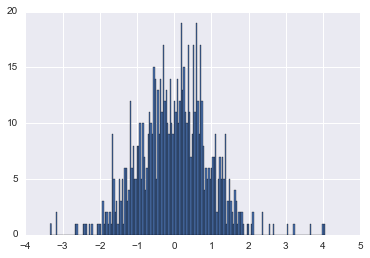

In [324]:
hist(out_std_resids, bins=200);

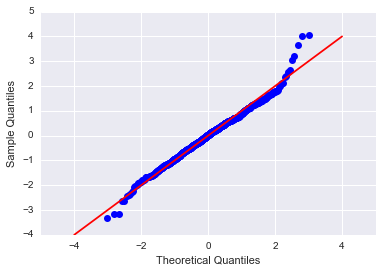

In [326]:
qqplot(out_std_resids)
q = linspace(-4,4)
plot(q, q, color='r')
show()

#### commentary on outlier removal

It doesn't seem that removing the outliers did much in this case. Our physical representations of the data have not changed much and our satistical analysis has not improved by a large margin. The biggest effect was that our beta p-values all got closer to zero.